# Support Vector Machine - Text Classification

In this notebook we will see how to train SVM classifiers to classify text documents. 

For a comparative understanding, we will compare the performance of the SVM with the Naive Bayes classifier. We will use 4 SVM algorithms to see which one is suitable for text classification.

Generally **text documents are linearly separable**. Based on this we formulate the following hypotheses:
- The linear SVM models should perform well.
- The kernelized SVM models will not bring any performance or efficiency benefit.

We will investige these hypotheses by conducting the following experiments.


## Experiments

- Experiment 1: Support Vector Machine (LinearSVC)
- Experiment 2: Support Vector Machine (SVC with Linear Kernel)
- Experiment 3: Support Vector Machine (SVC with RBF Kernel)
- Experiment 4: Support Vector Machine (Stochastic Gradient Descent using the SGDClassifier)
- Experiment 5: Naive Bayes Classifier (MultinomialNB Model)


## Dataset

URL: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection


#### Attribute Information:
- Ham SMS Messages:	4827
- Spam SMS Messages:	747

This corpus has been collected from free or free for research sources at the Internet: 

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. 
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. 
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis. 
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages.


## Steps for Classification:

1. Exploratory Data Analysis
2. Feature Extraction
   - a. Text Normalization (Stemming & Lemmatization)
   - b. Text Preprocessing (Tokenization, removing stop words, etc.)
   - c. Vectorization of the features
3. Model Selection by Hyper-parameter Tuning
4. Train the Optimal Model
5. Analyzing Model Performance
6. Evaluate the Model on Test Data

In [30]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package wordnet to /Users/hasan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

Load data from the CSV file as Pandas DataFrame object.

In [2]:
col_Names=["label_words", "text"]
df = pd.read_csv('/Users/hasan/datasets/SMSSpamCollection.csv', names=col_Names)

df['label'] = df['label_words'].map({'spam': 1, 'ham': 0})

# <font color=blue> 1. Exploratory Data Analysis</font>

## Quick Check of the Data

Let’s take a look at the top five rows using the DataFrame’s head() method.

In [3]:
df.head()

,label_words,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 3 columns):
label_words    5574 non-null object
text           5574 non-null object
label          5574 non-null int64
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [5]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("No. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (5574, 3)
No. of Rows: 5574
No. of Columns: 3


In [7]:
df.columns

Index(['label_words', 'text', 'label'], dtype='object')

## Class Distribution

In [6]:
df.groupby('label').count()

,label_words,text
label,,
0,4827,4827
1,747,747


## Visualization of the Class Distribution

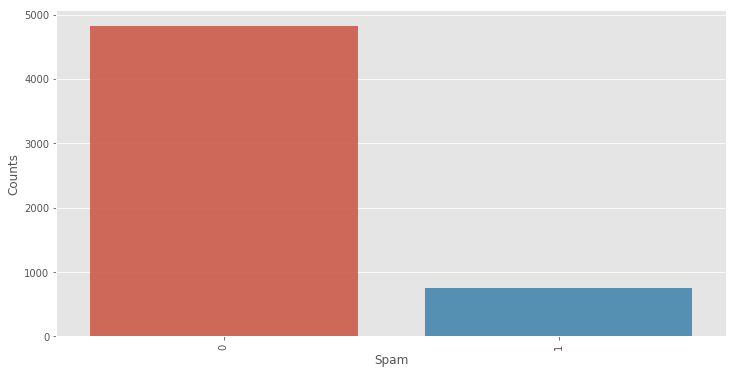

In [8]:
label_counts = df.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

## Correlation Between the Email length & the Class (Ham/Spam)

We need to check whether the length of the emails are correlated to their classes (ham/spam).

In [9]:
# Create a new column "length" the stores the length of the text on each row
df['length'] = df['text'].map(lambda text: len(text))

df.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,4827.0,71.527035,58.330761,2.0,33.0,52.0,93.0,910.0
1,747.0,139.119143,28.998900,13.0,133.0,149.0,158.0,224.0


## Visualize Length Distribution by Class

array([<matplotlib.axes._subplots.AxesSubplot object at 0x132acd3c8>,
      dtype=object)

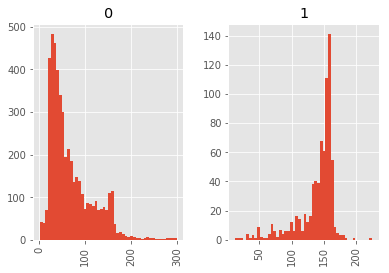

In [10]:
# Use a length threshold to visualize the distribution of length per class

emails_subset = df[df.length < 300]
emails_subset.hist(column='length', by='label', bins=50)

## Observation from the EDA

We observe that only 23.88% emails are spam.

Also there are outliers (long emails).

# <font color=blue> 2. Feature Extraction </font>

## a) Text Normalization by Lemmatization

Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.

Lemmatization is more suitable for text classification. Its the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. so word like 'moved' & 'moving' will be reduced to 'move'.

In [11]:
%%time
lemmatizer = WordNetLemmatizer()
df['text_lemmatized'] = df['text'].map(lambda text: (' '.join(lemmatizer.lemmatize(w.lower()) for w in nltk.word_tokenize(text.lower()))))

CPU times: user 4.85 s, sys: 143 ms, total: 4.99 s
Wall time: 5.03 s


In [12]:
print(df['text'][7])
print("\nLemmatized Email:\n")
print(df['text_lemmatized'][7])

As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune

Lemmatized Email:

a per your request 'melle melle ( oru minnaminunginte nurungu vettam ) ' ha been set a your callertune for all caller . press *9 to copy your friend callertune


## Generate Wordcloud of Spam SMS

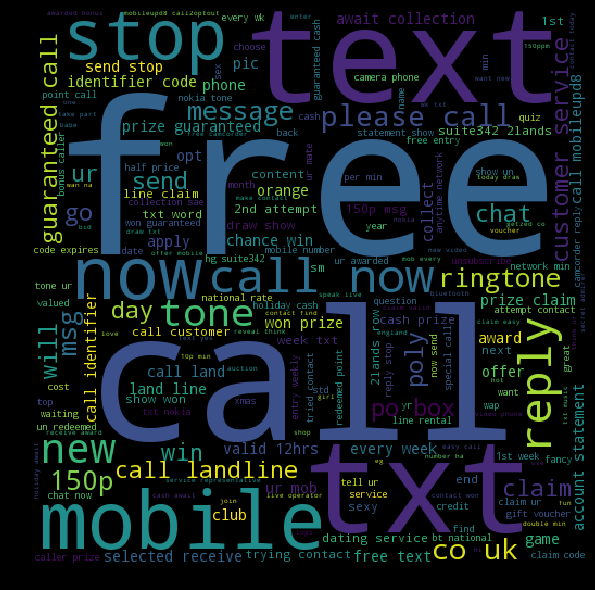

In [13]:
spam_words = ''.join(list(df[df['label']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Generate Wordcloud of Ham SMS

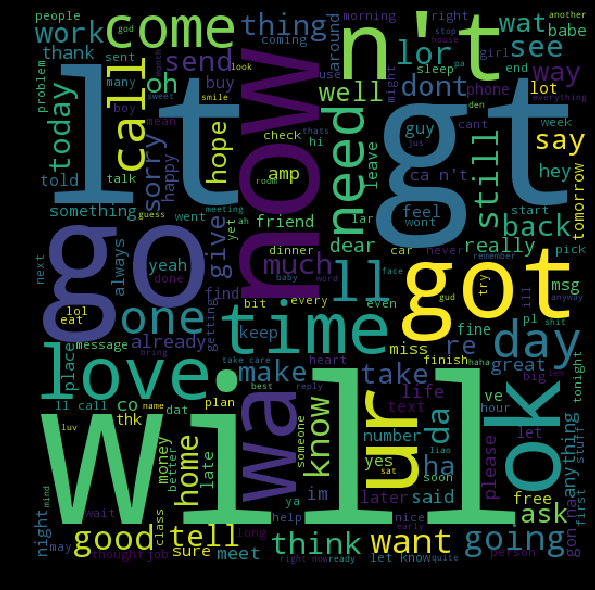

In [14]:
spam_words = ''.join(list(df[df['label']==0]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Create a Separate Feature Set (Data Matrix X) and Target (1D Vector y)

Create a data matrix (X) that contains all features and a 1D target vector (y) containing the target.

In [15]:
X = df["text_lemmatized"]

y = df['label'] # 1D targer vector

print(X.shape)
print(y.shape)

# Read the a random "email" from X
print("\nA random email:\n")
print(X[0])

(5574,)
(5574,)

A random email:

go until jurong point , crazy.. available only in bugis n great world la e buffet ... cine there got amore wat ...


## Create Train and Test Dataset

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# <font color=blue> 2. Feature Extraction </font>

## b) Text Preprocessing & c) Feature Vectorization

We will perform two tasks.
- Text Preprocessing
- Converting each document (email) into vectors of numbers

## Test Preprocessing

- Tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.
- Removing stop words.

## Converting Each Document (email) into Vectors of Numbers

There are two methods for counting the occurrences of tokens in each document.
- Bag of Words using CountVectorizer()
- TF-IDF using TfidfTransformer()

Note that CountVectorizer() performs the text preprocessing.

### <font color=red> Note: </font>

We can combine text preprocessing, feature vectorization and model training using the sklearn Pipeline object. This Pipeline object can be used for model selection and for training the optimal model. 



## Experiments

We will perform the following experiments.

- Experiment 1: Support Vector Machine (LinearSVC)
- Experiment 2: Support Vector Machine (SVC with Linear Kernel)
- Experiment 3: Support Vector Machine (SVC with RBF Kernel)
- Experiment 4: Support Vector Machine (Stochastic Gradient Descent using the SGDClassifier)
- Experiment 5: Naive Bayes Classifier (MultinomialNB Model)

## Experiment 1: Support Vector Machine (LinearSVC)


### Building a Pipeline for Hyperparameter Tuning

To denote the module objects in the Pipeline we use arbitrary names: "vect", "tfidf" and "clf".

We will use these names to perform grid search for suitable hyperparameters. 

In [18]:
svm_linearsvc = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LinearSVC(loss='hinge', random_state=42)),
    ])

## Experiment 1: Hyperparameter Tuning for LinearSVC Model

In [19]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__C': [0.1, 1, 5, 10],
}

svm_linearsvc_cv = GridSearchCV(svm_linearsvc, param_grid, scoring='accuracy', cv=5)

svm_linearsvc_cv = svm_linearsvc_cv.fit(X_train, y_train)


print("\nBest Score: %f" % svm_linearsvc_cv.best_score_)

print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, svm_linearsvc_cv.best_params_[param_name]))

/Users/hasan/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Best Score: 0.987665

Optimal Hyperparameter Values: 
clf__C: 1
vect__ngram_range: (1, 2)
vect__stop_words: None
CPU times: user 24.5 s, sys: 247 ms, total: 24.7 s
Wall time: 24.8 s


## Experiment 1: Train the Optimal LinearSVC Model 

In [20]:
%%time
svm_linearsvc = Pipeline([
        ('vect', CountVectorizer(stop_words=None, ngram_range=(1, 2), binary=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', LinearSVC(loss='hinge', C=1, random_state=42)),
    ])

svm_linearsvc.fit(X_train, y_train)  

CPU times: user 324 ms, sys: 10.2 ms, total: 334 ms
Wall time: 333 ms


## Experiment 1: Evaluate LinearSVC Model on Test Data 

In [55]:
%%time

y_test_predicted = svm_linearsvc.predict(X_test)

print("\nAccuracy: ", np.mean(y_test_predicted == y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Not Spam", "Spam"]))


Accuracy:  0.9874439461883409

Test Confusion Matrix:
[[951   3]
 [ 11 150]]

Test Precision = 0.987444

Test Recall = 0.987444

Test F1 Score = 0.987444

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.99      1.00      0.99       954
        Spam       0.98      0.93      0.96       161

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

CPU times: user 55 ms, sys: 2.21 ms, total: 57.2 ms
Wall time: 55.6 ms


## Experiment 2: Support Vector Machine (SVC with Linear Kernel)

### Building a Pipeline for Hyperparameter Tuning

In [24]:
svm_svc_linear = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(kernel='linear')),
    ])

## Experiment 2: Hyperparameter Tuning for SVC (Linear Kernel) Model

In [25]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__C': [0.1, 1, 5, 10],
}

svm_svc_linear_cv = GridSearchCV(svm_svc_linear, param_grid, scoring='accuracy', cv=5)

svm_svc_linear_cv = svm_svc_linear_cv.fit(X_train, y_train)


print("\nBest Score: %f" % svm_svc_linear_cv.best_score_)

print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, svm_svc_linear_cv.best_params_[param_name]))


Best Score: 0.987665

Optimal Hyperparameter Values: 
clf__C: 1
vect__ngram_range: (1, 2)
vect__stop_words: None
CPU times: user 2min 4s, sys: 556 ms, total: 2min 5s
Wall time: 2min 5s


## Experiment 2: Train the Optimal SVC (Linear Kernel) Model

In [26]:
%%time
svm_svc_linear = Pipeline([
        ('vect', CountVectorizer(stop_words=None, ngram_range=(1, 2), binary=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(kernel='linear', C=1, random_state=42)),
    ])

svm_svc_linear.fit(X_train, y_train)  

CPU times: user 1.72 s, sys: 13.3 ms, total: 1.74 s
Wall time: 1.74 s


## Experiment 2: Evaluate SVC (Linear Kernel) Model on Test Data

In [54]:
%%time

y_test_predicted = svm_svc_linear.predict(X_test)

print("\nAccuracy: ", np.mean(y_test_predicted == y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Not Spam", "Spam"]))


Accuracy:  0.9874439461883409

Test Confusion Matrix:
[[951   3]
 [ 11 150]]

Test Precision = 0.987444

Test Recall = 0.987444

Test F1 Score = 0.987444

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.99      1.00      0.99       954
        Spam       0.98      0.93      0.96       161

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

CPU times: user 365 ms, sys: 2.51 ms, total: 368 ms
Wall time: 366 ms


## Experiment 3: Support Vector Machine (SVC with RBF Kernel)

### Building a Pipeline for Hyperparameter Tuning

In [28]:
svm_svc_rbf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(kernel='rbf')),
    ])

## Experiment 3: Hyperparameter Tuning for SVC (RBF Kernel) Model

In [29]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': [0.1, 0.01, 0.001],
}

svm_svc_rbf_cv = GridSearchCV(svm_svc_rbf, param_grid, scoring='accuracy', cv=5)

svm_svc_rbf_cv = svm_svc_rbf_cv.fit(X_train, y_train)

print("\nBest Score: %f" % svm_svc_rbf_cv.best_score_)

print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, svm_svc_rbf_cv.best_params_[param_name]))


Best Score: 0.987441

Optimal Hyperparameter Values: 
clf__C: 100
clf__gamma: 0.01
vect__ngram_range: (1, 1)
vect__stop_words: None
CPU times: user 6min 40s, sys: 1.56 s, total: 6min 41s
Wall time: 6min 42s


## Experiment 3: Train the Optimal SVC (RBF Kernel) Model

In [31]:
%%time
svm_svc_rbf = Pipeline([
        ('vect', CountVectorizer(stop_words=None, ngram_range=(1, 2), binary=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)),
    ])

svm_svc_rbf.fit(X_train, y_train)  

CPU times: user 1.87 s, sys: 13.1 ms, total: 1.88 s
Wall time: 1.88 s


## Experiment 3: Evaluate SVC (RBF Kernel) Model on Test Data

In [53]:
%%time

y_test_predicted = svm_svc_rbf.predict(X_test)

print("\nAccuracy: ", np.mean(y_test_predicted == y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Not Spam", "Spam"]))


Accuracy:  0.9874439461883409

Test Confusion Matrix:
[[951   3]
 [ 11 150]]

Test Precision = 0.987444

Test Recall = 0.987444

Test F1 Score = 0.987444

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.99      1.00      0.99       954
        Spam       0.98      0.93      0.96       161

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

CPU times: user 403 ms, sys: 3.11 ms, total: 406 ms
Wall time: 405 ms


## Experiment 4: Support Vector Machine (Stochastic Gradient Descent using the SGDClassifier)


### Building a Pipeline for Hyperparameter Tuning

In [33]:
%%time

svm_sgd = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge')),
    ])

CPU times: user 149 µs, sys: 0 ns, total: 149 µs
Wall time: 164 µs


## Experiment 4: Hyperparameter Tuning for SGDClassifier Model

In [34]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__alpha': [1e-4, 1e-5],
    'clf__penalty': ['l2', 'l1'],
}

svm_sgd_cv = GridSearchCV(svm_sgd, param_grid, scoring='accuracy', cv=5)

svm_sgd_cv = svm_sgd_cv.fit(X_train, y_train)

print("\nBest Score: %f" % svm_sgd_cv.best_score_)

print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, svm_sgd_cv.best_params_[param_name]))

/Users/hasan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)



Best Score: 0.987890

Optimal Hyperparameter Values: 
clf__alpha: 0.0001
clf__penalty: 'l2'
vect__ngram_range: (1, 2)
vect__stop_words: None
CPU times: user 22.2 s, sys: 294 ms, total: 22.5 s
Wall time: 22.5 s


## Experiment 4: Train the Optimal SGDClassifier Model

In [35]:
%%time

svm_sgd = Pipeline([
        ('vect', CountVectorizer(stop_words=None, ngram_range=(1, 2), binary=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, random_state=42, max_iter=100, tol=1e-1)),
    ])

svm_sgd.fit(X_train, y_train)  

CPU times: user 309 ms, sys: 9.8 ms, total: 319 ms
Wall time: 317 ms


## Experiment 4: Evaluate SGDClassifier Model on Test Data

In [52]:
%%time

y_test_predicted = svm_sgd.predict(X_test)

print("\nAccuracy: ", np.mean(y_test_predicted == y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Not Spam", "Spam"]))


Accuracy:  0.9883408071748879

Test Confusion Matrix:
[[951   3]
 [ 10 151]]

Test Precision = 0.988341

Test Recall = 0.988341

Test F1 Score = 0.988341

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.99      1.00      0.99       954
        Spam       0.98      0.94      0.96       161

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115

CPU times: user 56.1 ms, sys: 1.55 ms, total: 57.6 ms
Wall time: 56.7 ms


# Experiment 5: Naive Bayes Classifier (MultinomialNB Model)


### Building a Pipeline for Hyperparameter Tuning

In [41]:
clf_multinomialNB = Pipeline([
        ('vect', CountVectorizer()),
        #('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])

## Experiment 5: Hyperparameter Tuning for Multinomial NB Model

In [42]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__alpha': [1e-1, 1.0, 1.5, 1.8],
}

clf_multinomialNB_cv = GridSearchCV(clf_multinomialNB, param_grid, scoring='f1', cv=5)

clf_multinomialNB_cv = clf_multinomialNB_cv.fit(X_train, y_train)


print("\nBest Score: %f" % clf_multinomialNB_cv.best_score_)

print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, clf_multinomialNB_cv.best_params_[param_name]))


Best Score: 0.942690

Optimal Hyperparameter Values: 
clf__alpha: 1.5
vect__ngram_range: (1, 2)
vect__stop_words: 'english'
CPU times: user 20.6 s, sys: 230 ms, total: 20.9 s
Wall time: 20.9 s


## Experiment 5: Train the Optimal Multinomial NB Model

In [49]:
%%time
clf_multinomialNB = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=False)),
        #('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(alpha=0.1)),
    ])

clf_multinomialNB.fit(X_train, y_train)  

CPU times: user 215 ms, sys: 4.22 ms, total: 219 ms
Wall time: 218 ms


## Experiment 5: Evaluate Multinomial NB Model on Test Data

In [51]:
y_test_predicted = clf_multinomialNB.predict(X_test)

print("\nAccuracy: ", np.mean(y_test_predicted == y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Not Spam", "Spam"]))


Accuracy:  0.9865470852017937

Test Confusion Matrix:
[[948   6]
 [  9 152]]

Test Precision = 0.962025
Test Recall = 0.944099
Test F1 Score = 0.952978

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99       954
        Spam       0.96      0.94      0.95       161

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.98      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



# Summary of Results from 5 Experiments

In [56]:
data = [["LinearSVC", 0.98744, "333 ms"], 
        ["SVC (Linear Kernel)", 0.98744, "1.7 s"],
        ["SVC (RBF Kernel)", 0.98744, "1.88 s"],
        ["SGD SVM", 0.98834, "317 ms"],
        ["Multinomial NB", 0.98654, "218 ms"]]

pd.DataFrame(data, columns=["Classifier", "Accuracy", "Running-Time"])

,Classifier,Accuracy,Running-Time
0,LinearSVC,0.98744,333 ms
1,SVC (Linear Kernel),0.98744,1.7 s
2,SVC (RBF Kernel),0.98744,1.88 s
3,SGD SVM,0.98834,317 ms
4,Multinomial NB,0.98654,218 ms


# Comparative Understanding

We have done 5 experiments using SVM and NB classifiers.

The first 4 experiements are done using various SVM algorithms.

The experimental results confirm our hypotheses:
- The linear SVM models should perform well.
- The kernelized SVM models will not bring any performance or efficiency benefit.


We make following observations.

- The **SGD based SVM performs the best and it is the fastest**. It uses Stochastic Gradient Descent algorithm with the Hinge loss cost function. We implemented the l2 regularized version of the model.
- The RBF kernel based SVM did not show any performance improvement. This result is expected. Generally text classification data are linearly separable. Thus linear models should perform well. In other words, for text classification problems we should first try the linear SVM models.
- The **LinearSVC is faster than the SVC with Linear Kernel**. Because it scales linearly with the number of training instances and the number of features, unlike the kernelized SVM that solves the dual problem whose complexity is quadratic (at best) with the number of instances. Thus, for **text classification problems we should always try the LinearSVC first (not the Linear kernel based SVC)**.
- Finally, the SVM models perform slightly better than the NB classifier. However, all SVM models require TF-IDF features, unlike the NB model.